# Author
[Bete (Ranma-2000)](https://github.com/Ranma-2000)

## Import libs

In [2]:
import os
import glob

import pandas as pd
import wfdb as wf
import numpy as np
from scipy import signal
import utils.mitdbread as dm
from biosppy.signals import ecg  # R peaks detection algorithm 1
from utils import *  # R peaks detection algorithm 2
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading data files

In [3]:
records = dm.get_records()
print(records)

['data/mitdb\\100', 'data/mitdb\\101', 'data/mitdb\\102', 'data/mitdb\\103', 'data/mitdb\\104', 'data/mitdb\\105', 'data/mitdb\\106', 'data/mitdb\\107', 'data/mitdb\\108', 'data/mitdb\\109', 'data/mitdb\\111', 'data/mitdb\\112', 'data/mitdb\\113', 'data/mitdb\\114', 'data/mitdb\\115', 'data/mitdb\\116', 'data/mitdb\\117', 'data/mitdb\\118', 'data/mitdb\\119', 'data/mitdb\\121', 'data/mitdb\\122', 'data/mitdb\\123', 'data/mitdb\\124', 'data/mitdb\\200', 'data/mitdb\\201', 'data/mitdb\\202', 'data/mitdb\\203', 'data/mitdb\\205', 'data/mitdb\\207', 'data/mitdb\\208', 'data/mitdb\\209', 'data/mitdb\\210', 'data/mitdb\\212', 'data/mitdb\\213', 'data/mitdb\\214', 'data/mitdb\\215', 'data/mitdb\\217', 'data/mitdb\\219', 'data/mitdb\\220', 'data/mitdb\\221', 'data/mitdb\\222', 'data/mitdb\\223', 'data/mitdb\\228', 'data/mitdb\\230', 'data/mitdb\\231', 'data/mitdb\\232', 'data/mitdb\\233', 'data/mitdb\\234']


## 2. Data preprocessing

### 2.1. ECG Detection

#### 2.1.1. Implement ECG algorithm

### 2.1.2. Use biosppy package

In [27]:
# Instead of using the annotations to find the beats, we will
# use R-peak detection instead. The reason for this is so that
# the same logic can be used to analyze new and un-annotated
# ECG data. We use the annotations here only to classify the
# beat as either Normal or Abnormal and to train the model.
# Reference:
# https://physionet.org/physiobank/database/html/mitdbdir/intro.htm
realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

# Loop through each input file. Each file contains one
# record of ECG readings, sampled at 360 readings per
# second.
for path in records:
    pathpts = path.split('/')
    fn = pathpts[-1]
    print('Loading file:', path)

    # Read in the data
    record = wf.rdsamp(path)
    annotation = wf.rdann(path, 'atr')

    # Print some meta informations
    print('    Sampling frequency used for this record:', record[1].get('fs'))
    print('    Shape of loaded data array:', record[0].shape)
    print('    Number of loaded annotations:', len(annotation.num))

    # Get the ECG values from the file.
    data = record[0].transpose()

    # Generate the classifications based on the annotations.
    # 0.0 = undetermined
    # 1.0 = normal
    # 2.0 = abnormal
    cat = np.array(annotation.symbol)
    print(cat)
    rate = np.zeros_like(cat, dtype='float')
    for catid, catval in enumerate(cat):
        print(catval)
        if (catval == 'N'):
            rate[catid] = 1.0 # Normal
        elif (catval in realbeats):
            rate[catid] = 2.0 # Abnormal
    rates = np.zeros_like(data[0], dtype='float')
    rates[annotation.sample] = rate

    indices = np.arange(data[0].size, dtype='int')

    # Process each channel separately (2 per input file).
    for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('    ECG channel type:', chname)

        # Find rpeaks in the ECG data. Most should match with
        # the annotations.
        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0

        # Calculate Median R-R peaks time interval
        list_time_interval = []
        for i in range(0, len(out['rpeaks']) - 1):
            time_interval = out['rpeaks'][i+1] - out['rpeaks'][i]
            list_time_interval.append(time_interval)
        mean_time_interval = sum(list_time_interval) / len(list_time_interval)

        beatstoremove = np.array([0])

        # Split into individual heartbeats. For each heartbeat
        # record, append classification (normal/abnormal).
        beats = np.split(channel, out['rpeaks'])
        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Skip first and last beat.
            if (firstround or lastround):
                continue

            # Get the classification value that is on
            # or near the position of the rpeak index.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10
            catval = rates[fromidx:toidx].max()

            # Skip beat if there is no classification.
            if (catval == 0.0):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Normal beat is now classified as 0.0 and abnormal is 1.0.
            catval = catval - 1.0

            # Append some extra readings from next beat.
            beats[idx] = np.append(beats[idx], beats[idx+1][:int(0.2*mean_time_interval)])

            # Normalize the readings to a 0-1 range for ML purposes.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Skipping records that are too long.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Pad with zeroes.
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Append the classification to the beat data.
            beats[idx] = np.append(beats[idx], catval)

        beatstoremove = np.append(beatstoremove, len(beats)-1)

        # Remove first and last beats and the ones without classification.
        beats = np.delete(beats, beatstoremove)

        # Save to CSV file.
        savedata = np.array(list(beats[:]), dtype=np.float)
        outfn = os.path.join('data/extracted_data', f'{fn}_{chname}.csv')
        print('        Generating ', outfn)
        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')

Loading file: data/mitdb\100
    Sampling frequency used for this record: 360
    Shape of loaded data array: (650000, 2)
    Number of loaded annotations: 2274
['+' 'N' 'N' ... 'N' 'N' 'N']
+
N
N
N
N
N
N
N
A
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
A
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
A
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
A
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N
N

### 2.2. Data Extraction Method

#### 2.2.1. Based on arxiv 1805.00794

#### 2.2.2. Sliding Window

### 2.3. Visualize Extracted Data

In [29]:
data = np.loadtxt('data/extracted_data/mitdb/100_MLII.csv', delimiter=',')
print(data.shape)

(2270, 188)


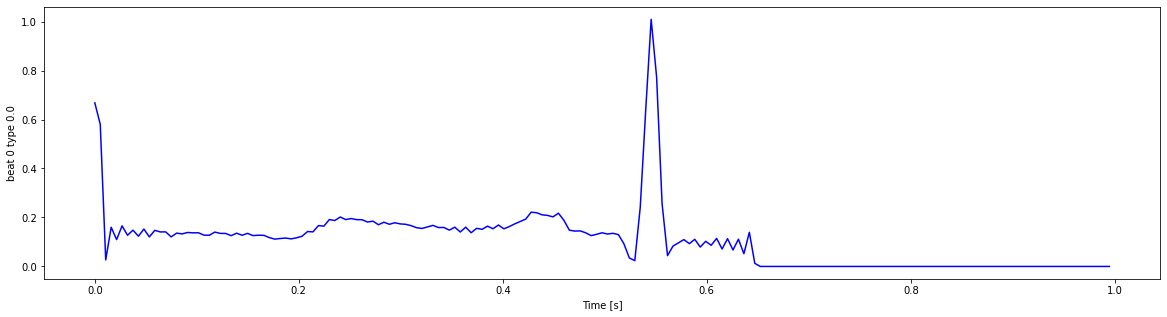

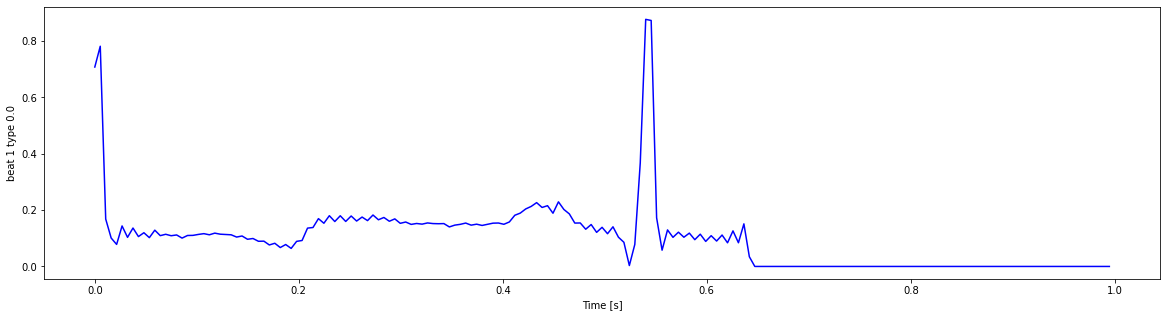

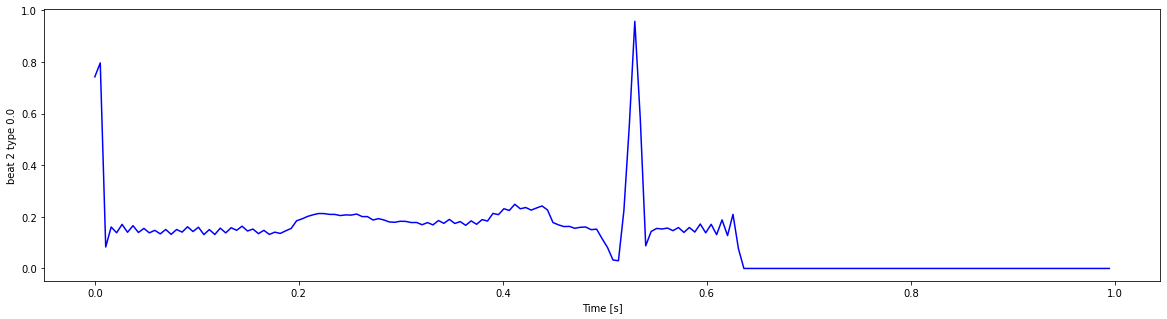

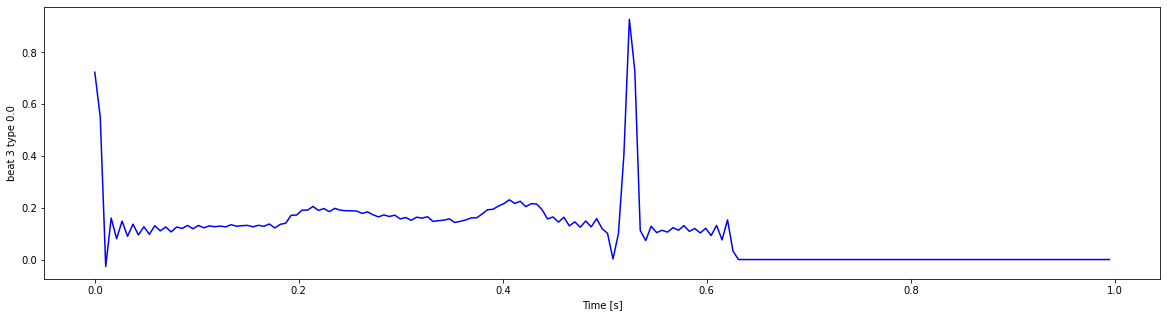

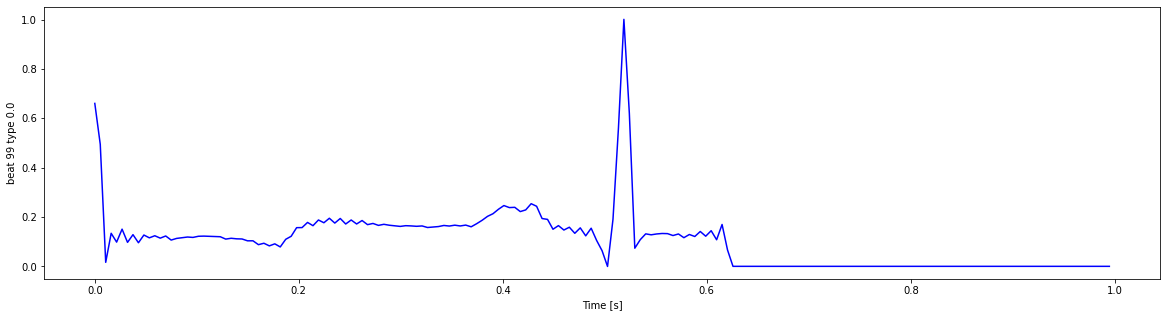

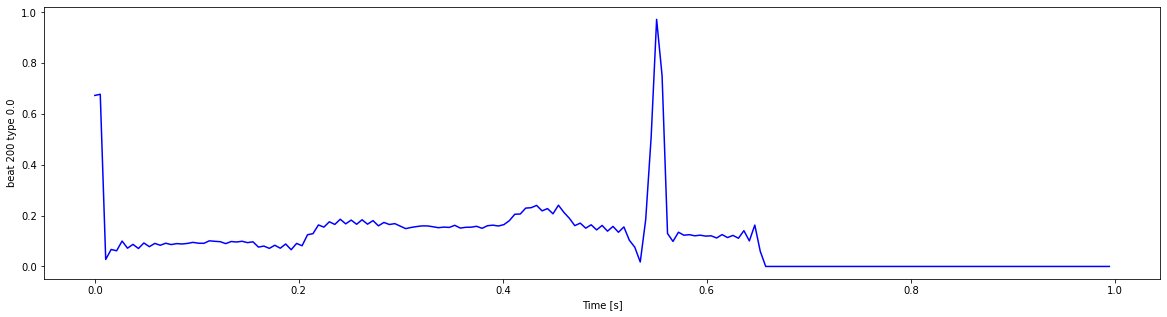

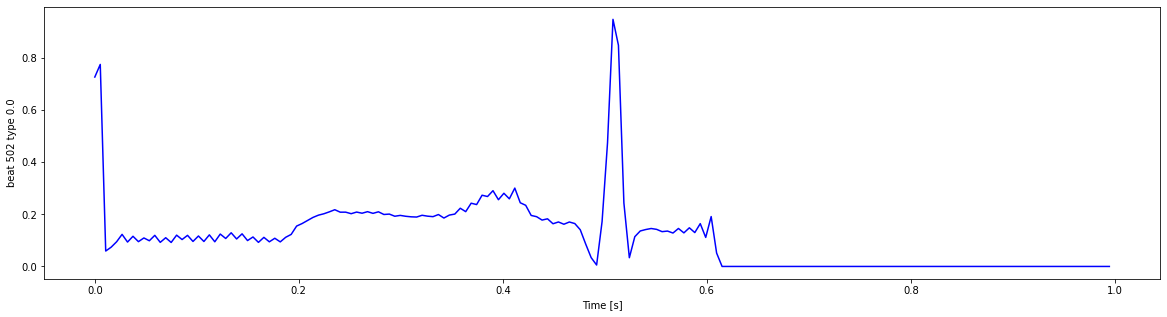

In [40]:
# Visualize 100
for beatid in [0,1,2,3,99,200,502]:
    times = np.arange(187, dtype = 'float') / 187
    beat = data[beatid][:-1]
    anno = data[beatid][-1]
    plt.figure(figsize=(20,5))
    if (anno == 0.0):  # Normal beat
      plt.plot(times, beat, 'b')
    else:  # Abnormal beat
      plt.plot(times, beat, 'r')
    plt.xlabel('Time [s]')
    plt.ylabel('beat ' + str(beatid) + " type " + str(anno))
    plt.show()

### 2.4. Split Data into training and test set

In [36]:
alldata = np.empty(shape=[0, 188])
print(alldata.shape)
paths = glob.glob('data/extracted_data/mitdb/*.csv')
for path in paths:
    print('Loading ', path)
    csvrows = np.loadtxt(path, delimiter=',')
    alldata = np.append(alldata, csvrows, axis=0)

(0, 188)
Loading  data/extracted_data/mitdb\100_MLII.csv
Loading  data/extracted_data/mitdb\100_V5.csv
Loading  data/extracted_data/mitdb\101_MLII.csv
Loading  data/extracted_data/mitdb\101_V1.csv
Loading  data/extracted_data/mitdb\102_V2.csv
Loading  data/extracted_data/mitdb\102_V5.csv
Loading  data/extracted_data/mitdb\103_MLII.csv
Loading  data/extracted_data/mitdb\103_V2.csv
Loading  data/extracted_data/mitdb\104_V2.csv
Loading  data/extracted_data/mitdb\104_V5.csv
Loading  data/extracted_data/mitdb\105_MLII.csv
Loading  data/extracted_data/mitdb\105_V1.csv
Loading  data/extracted_data/mitdb\106_MLII.csv
Loading  data/extracted_data/mitdb\106_V1.csv
Loading  data/extracted_data/mitdb\107_MLII.csv
Loading  data/extracted_data/mitdb\107_V1.csv
Loading  data/extracted_data/mitdb\108_MLII.csv
Loading  data/extracted_data/mitdb\108_V1.csv
Loading  data/extracted_data/mitdb\109_MLII.csv
Loading  data/extracted_data/mitdb\109_V1.csv
Loading  data/extracted_data/mitdb\111_MLII.csv
Loading

In [37]:
# Shuffle and split
# Randomly mix rows
np.random.shuffle(alldata)
totrows = len(alldata)
trainrows = int((totrows * 3 / 5) + 0.5) # 60%
testrows = int((totrows * 1 / 5) + 0.5) # 20%
validaterows = totrows - trainrows - testrows # 20%
mark1 = trainrows
mark2 = mark1 + testrows

In [39]:
# Save data
with open('data/seperated_data/mitdb/train.csv', "wb") as fin:
    np.savetxt(fin, alldata[:mark1], delimiter=",", fmt='%f')

with open('data/seperated_data/mitdb/test.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark1:mark2], delimiter=",", fmt='%f')

with open('data/seperated_data/mitdb/validate.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark2:], delimiter=",", fmt='%f')

## 3. Generate real-time data from device

In this section, I will generate data that the device can't sensor heartbeat. Why would I do that?
1. Hardware has limitation. Currently, the device can't raise a flag where error appears while taking heartbeat.

So, my solution is get that data and label them as "Hardware error" category.

In [26]:
data_path = 'data/data_pipeline/realtime_from_com/sample_1'
heartbeat_data = []
rpeaks_data = []
for i in range(1, 370, 1):
    data = pd.read_csv(os.path.join(data_path, f'{i}.csv'), header=None)
    beats = list()
    for p in data.to_numpy():
        beats.append(p[0])
    beats = np.array(beats)
    heartbeat_data.append(beats)
    out = ecg.ecg(signal=beats, sampling_rate=125, show=False)
    rpeaks = out['rpeaks']
    rpeaks_data.append(rpeaks)

Visualize data

80
[  55  133  216  305  397  488  577  660  742  822  905  995 1091 1181]
[  58  136  219  308  400  491  580  663  744  824  908  997 1094 1184]
[9.65761421e+03 8.51578557e+03 6.96237290e+03 5.44759551e+03
 4.36355800e+03 3.87448716e+03 3.87127780e+03 4.08573910e+03
 4.27682669e+03 4.34155243e+03 3.74553641e+03 3.24616137e+03
 2.96189973e+03 2.87968105e+03 2.90215113e+03 2.88928025e+03
 2.72342876e+03 2.39375880e+03 1.98760891e+03 1.59702117e+03
 1.27311375e+03 1.05139411e+03 9.55222624e+02 9.49068235e+02
 9.24883745e+02 7.95035060e+02 5.76262074e+02 3.53244104e+02
 1.93972014e+02 1.10021822e+02 7.44313551e+01 5.98790322e+01
 5.48748411e+01 5.35110780e+01 5.27157889e+01 6.15788147e+01
 9.22107557e+01 1.29718059e+02 1.37733442e+02 1.20019062e+02
 1.30486210e+02 1.75067067e+02 1.87899687e+02 2.23069704e+02
 6.38395225e+02 1.89053948e+03 3.84664109e+03 5.32171312e+03
 5.42112041e+03 7.07295817e+03 1.82520211e+04 4.35825050e+04
 7.11941525e+04 8.12689355e+04 8.16921878e+04 1.08952659e+05

ValueError: x and y must have same first dimension, but have shapes (2,) and (219,)

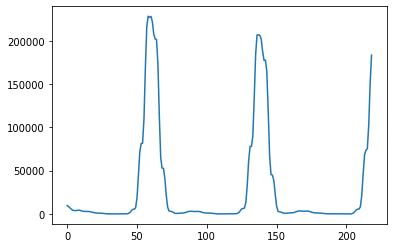

In [105]:
import utils.Pan_tompkins as pt
for i in range(80, 90, 1):
    print(i)
    singal = pt.Pan_tompkins(heartbeat_data[i], 125)
    # signal_data = signal.fit()

    out = ecg.ecg(signal=singal.fit(), sampling_rate=125, show=False)
    print(rpeaks_data[i])
    print(out['rpeaks'])

    # plt.plot(heartbeat_data[i])
    # plt.plot(rpeaks_data[i], heartbeat_data[i][rpeaks_data[i]], 'r-o')
    # plt.plot(out['rpeaks'], heartbeat_data[i][out['rpeaks']], 'y-o')
    # plt.show()
    print(singal.fit()[0:out['rpeaks'][2]])
    plt.plot(singal.fit()[0:out['rpeaks'][2]])
    plt.plot(out['rpeaks'][0:2], singal.fit()[0:out['rpeaks'][2]], 'y-o')
    plt.show()


In [ ]:
# 10, 190, 305, 365